In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN

plt.rcParams.update({'font.size': 2})

In [2]:
def binarize_image(image):
    # 0 is a throwaway param, Otsu will determine
    threshold, binarized = \
        cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    binarized = (image < 1.0*threshold).astype(int)  # sets a higher threshold
    return binarized

# Input:
#  - cluster: List of (x, y) coordinates corresponding to points in the cluster
#  - coordinate_bounds: Generally the shape of the original image, in (x, y) form.
# Output:
#  - centroid: [x, y]
#  - box_x: [min_x, max_x] of the bounding box
#  - box_y: [min_y, max_y] of the bounding box
def compute_centroid(cluster, coordinate_bounds):
    y, x = np.mean(cluster, axis=0).astype(int) # cast early so we don't have to cast the boxes
    centroid = [x, y]

    min_x = np.min(cluster[:, 1])
    max_x = np.max(cluster[:, 1])
    size_x = max(15, int(1.0*(max_x - min_x)))
    box_x = [max(0, x - size_x), min(coordinate_bounds[1], x + size_x)]

    min_y = np.min(cluster[:, 0])
    max_y = np.max(cluster[:, 0])
    size_y = max(15, int(1.0*(max_y - min_y)))
    box_y = [max(0, y - size_y), min(coordinate_bounds[0], y + size_y)]
    
    return centroid, box_x, box_y

# Input:
#  - image: binary image
#  - threshold [0-1]: only remove elements less that make up less than threshold
#    amount of total elements
# Output: input image with border elements removed
def remove_border_elements(image, threshold):
    num_components, labelled, stats, centroids = \
        cv2.connectedComponentsWithStats(image, 8, cv2.CV_32S)  # 8-connectivity includes diagonals
    total_size = sum(stats[1:,-1])  # 0 is the background component

    border_filter = np.ones(labelled.shape).astype(int)
    border_filter[1:-1, 1:-1] = 0

    for c in range(1, num_components):  # 0 is the background component
        component = (labelled == c).astype(int)
        if np.sum(component & border_filter) > 0 and np.sum(component) < threshold*total_size:
            image = image & (1-component)
    
    return image

# Read initial image and find centroids

Image dimensions: (832, 1128)


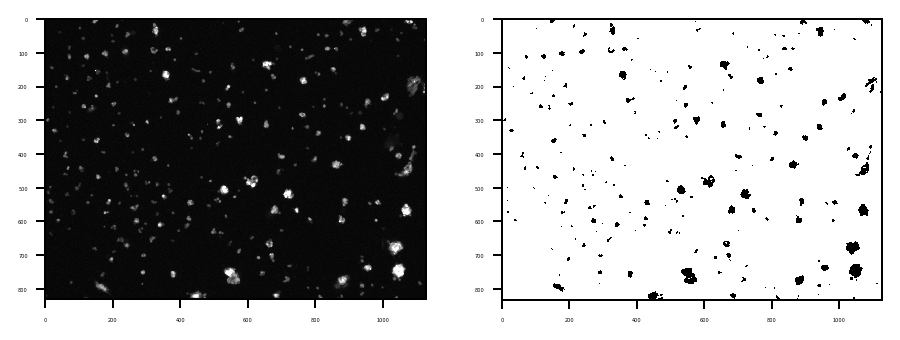

In [3]:
rfp = cv2.imreadmulti('RFP-1.tif')[1]
# bf = cv2.imreadmulti('BF-1.tif')[1]

initial_image = rfp[0]
initial_binarized = binarize_image(initial_image)

coordinate_bounds = initial_image.shape
print("Image dimensions: " + str(coordinate_bounds))

plt.figure(dpi=180)
plt.subplot(1,2,1)
plt.imshow(initial_image, interpolation='nearest', cmap='gray')
plt.subplot(1,2,2)
plt.imshow(initial_binarized, interpolation='nearest', cmap='gray')
plt.show()

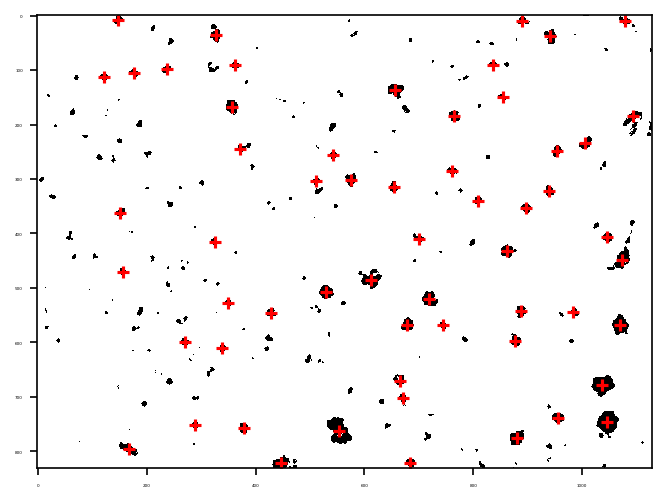

In [4]:
cell_points = np.argwhere(1-initial_binarized)
clustering = DBSCAN(eps=6, min_samples=100).fit(cell_points)
labels = clustering.labels_

centroids = []
boxes_x = []
boxes_y = []

# Note that clustering.labels_ includes -1, which are noisy samples.
# Thus, enforce starting at 0 rather than min(labels).
for i in range(0, max(labels)+1):
    indices = np.where(labels == i)
    cluster = cell_points[indices]
    if np.max(cluster[:, 1]) - np.min(cluster[:, 1]) >= 9 and \
       np.max(cluster[:, 0]) - np.min(cluster[:, 0]) >= 9:
        centroid, box_x, box_y = compute_centroid(cluster, coordinate_bounds)

        centroids += [centroid,]
        boxes_x += [box_x,]
        boxes_y += [box_y,]
    
centroids = np.array(centroids)
boxes_x = np.array(boxes_x)
boxes_y = np.array(boxes_y)

plt.figure(dpi=150)
plt.imshow(initial_binarized, interpolation='nearest', cmap='gray')
plt.scatter(*zip(*centroids), c='r', marker='+')
plt.show()

# Iterate on second image

In [5]:
image = rfp[1]

# saving boxes for display purposes
boxes = []
filtered_boxes = []

new_centroids = []
new_boxes_x = []
new_boxes_y = []
for i in range(len(centroids)):
    centroid = centroids[i]
    box_x = boxes_x[i]
    box_y = boxes_y[i]

    box = image[max(0,box_y[0]):min(box_y[1],image.shape[0]),
                           max(0,box_x[0]):min(box_x[1],image.shape[1])]
    filtered = cv2.Canny(np.uint8(box), threshold1=100, threshold2=230)
    cluster = np.argwhere(remove_border_elements(filtered, 0.25))
    boxes += [box,]
    filtered_boxes += [filtered,]

    # Need to ensure cell is inside the box
    if len(cluster) > 0:
        sub_centroid, sub_box_x, sub_box_y = compute_centroid(cluster, coordinate_bounds)

        centroid = np.array(sub_centroid) + np.array([box_x[0], box_y[0]])
        box_x = sub_box_x + box_x[0]
        box_y = sub_box_x + box_y[0]

        new_centroids += [centroid,]
        new_boxes_x += [box_x,]
        new_boxes_y += [box_y,]

new_centroids = np.array(new_centroids)
new_boxes_x = np.array(new_boxes_x)
new_boxes_y = np.array(new_boxes_y)

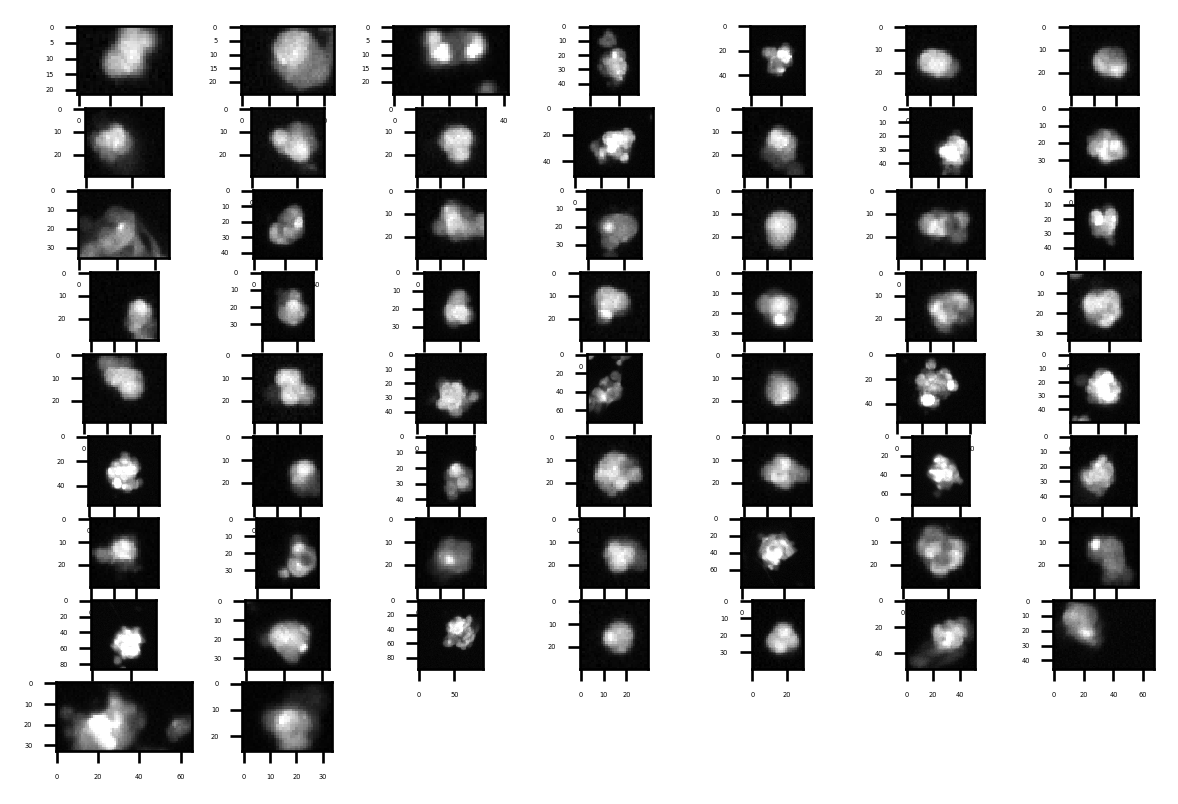

In [6]:
cols = 7
rows = int(len(boxes) / cols) + 1

plt.figure(dpi=240)
for i in range(len(boxes)):
    plt.subplot(rows,cols,i+1)
    plt.imshow(boxes[i], interpolation='nearest', cmap='gray')
plt.show()

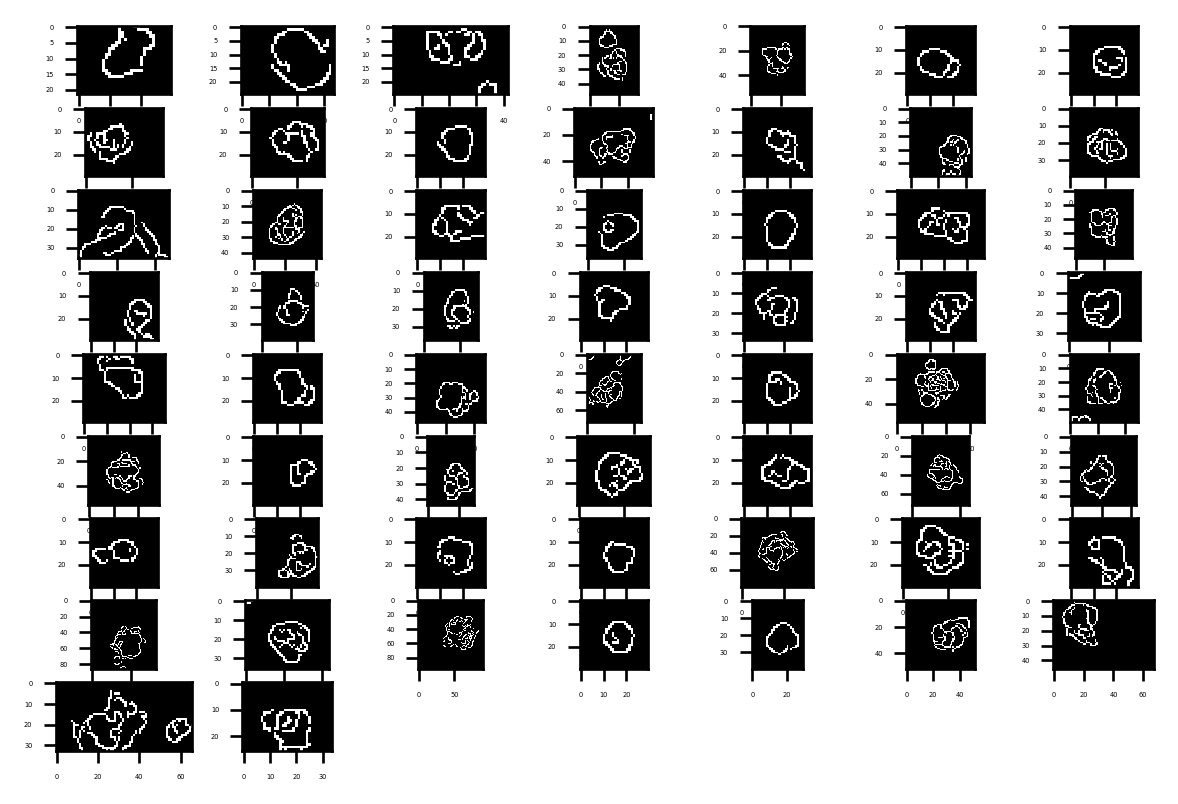

In [7]:
plt.figure(dpi=240)
for i in range(len(filtered_boxes)):
    plt.subplot(rows,cols,i+1)
    plt.imshow(filtered_boxes[i], interpolation='nearest', cmap='gray')
plt.show()

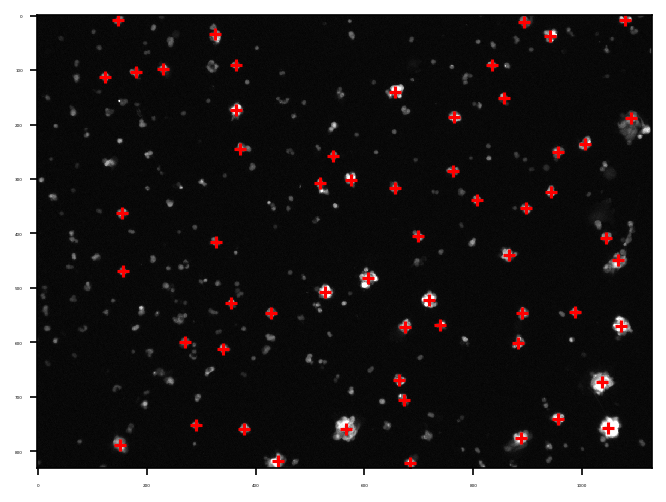

In [8]:
plt.figure(dpi=150)
plt.imshow(image, interpolation='nearest', cmap='gray')
plt.scatter(*zip(*new_centroids), c='r', marker='+')
plt.show()

# Proof of concept for border filtering.

This does not affect tracking behavior - we remove these border elements prior to computing the new centroids, not after.

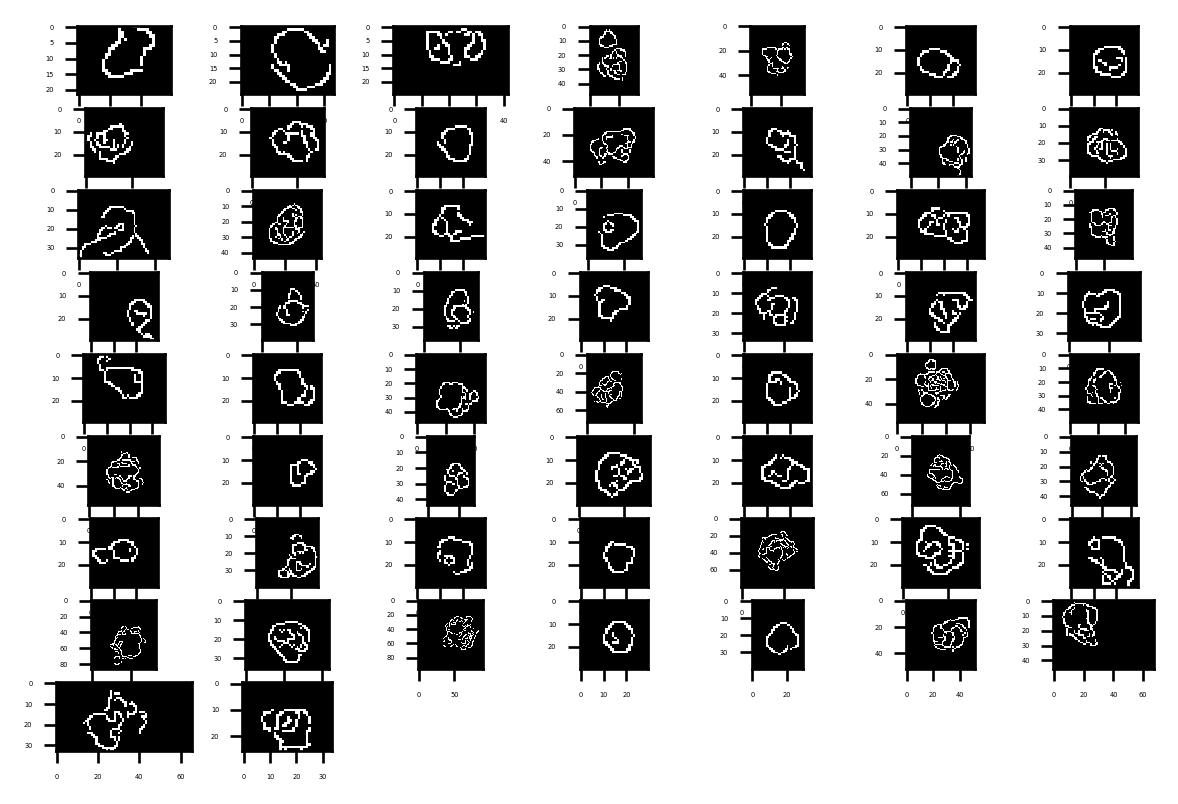

In [9]:
plt.figure(dpi=240)
for i in range(len(filtered_boxes)):
    plt.subplot(rows,cols,i+1)
    plt.imshow(remove_border_elements(filtered_boxes[i], 0.25), interpolation='nearest', cmap='gray')
plt.show()

# Proof of Concept for LoG and Canny

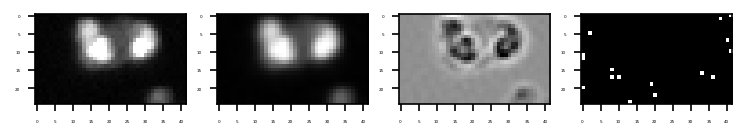

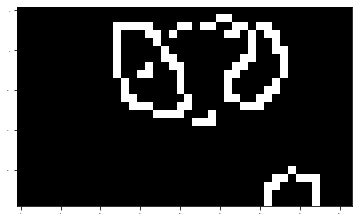

In [10]:
centroid = centroids[2]
box_x = boxes_x[2]
box_y = boxes_y[2]

# LoG
image = rfp[1]
box = image[box_y[0]:box_y[1], box_x[0]:box_x[1]]
blurred = cv2.GaussianBlur(np.float64(box), (3,3), 0)
filtered = cv2.Laplacian(np.float64(blurred), cv2.CV_64F)
edges = (filtered == 0).astype(int)  # need to threshold this

plt.figure(dpi=150)
plt.subplot(1,4,1)
plt.imshow(box, interpolation='nearest', cmap='gray')
plt.subplot(1,4,2)
plt.imshow(blurred, interpolation='nearest', cmap='gray')
plt.subplot(1,4,3)
plt.imshow(filtered, interpolation='nearest', cmap='gray')
plt.subplot(1,4,4)
plt.imshow(edges, interpolation='nearest', cmap='gray')
plt.show()

# Canny
box = rfp[1][box_y[0]:box_y[1], box_x[0]:box_x[1]]
filtered = cv2.Canny(np.uint8(box), threshold1=100, threshold2=230)
plt.imshow(filtered, interpolation='nearest', cmap='gray')